--- Starting Data Collection Across All Datasets ---

Processing dataset: gpqa_diamond
 Processing model: QwQ-32B
  Processed QwQ-32B, dataset gpqa_diamond, 2. Accuracy = 62.1212
  Processed QwQ-32B, dataset gpqa_diamond, 8. Accuracy = 65.1515
  Processed QwQ-32B, dataset gpqa_diamond, 16. Accuracy = 68.1818
  Processed QwQ-32B, dataset gpqa_diamond, 32. Accuracy = 67.1717
  Processed QwQ-32B, dataset gpqa_diamond, 64. Accuracy = 66.1616
 Processing model: R1-Distill-Qwen-14B
  Processed R1-Distill-Qwen-14B, dataset gpqa_diamond, 2. Accuracy = 55.0505
  Processed R1-Distill-Qwen-14B, dataset gpqa_diamond, 8. Accuracy = 63.1313
  Processed R1-Distill-Qwen-14B, dataset gpqa_diamond, 16. Accuracy = 60.6061
  Processed R1-Distill-Qwen-14B, dataset gpqa_diamond, 32. Accuracy = 61.6162
  Processed R1-Distill-Qwen-14B, dataset gpqa_diamond, 64. Accuracy = 63.6364

Processing dataset: aime
 Processing model: QwQ-32B
  Processed QwQ-32B, dataset aime, 2. Accuracy = 80.0000
  Processed QwQ-32B, 

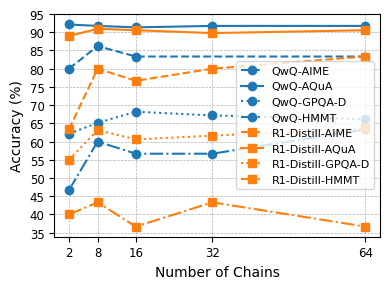


--- Finished combined plot with custom legend ---


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.ticker as ticker
import os
# import seaborn as sns # Removed seaborn import as theme is removed
import numpy as np

# Configure matplotlib for better display
# %config InlineBackend.figure_format = 'retina' # Keep this if running in Jupyter - Commenting out as this is notebook specific

# --- Configuration ---

from pathlib import Path
user = os.environ.get("USER", "default_user")
BASE_RESULTS_PATH = Path(f"/home/users/ntu/{user}/slimsc/prune/results")

# Define the models and their respective ROOT paths (before dataset name)
models_config = {
    "QwQ-32B": f"{BASE_RESULTS_PATH}/QwQ-32B/",
    "R1-Distill-Qwen-14B": f"{BASE_RESULTS_PATH}/R1-Distill-Qwen-14B/",
}

# Define the benchmark datasets to process
datasets_to_process = ["gpqa_diamond", "aime", "aqua_rat", "hmmt"]

# Define the sc_i values to compare
sc_i_values = [2, 8, 16, 32, 64]
file_name = "evaluation_summary.csv"

# Configure matplotlib for better display (removed seaborn theme)
# No need to call seaborn.set_theme anymore

# --- Define Color/Style/Marker Mappings based on Reference Code ---
# Define a specific color for each model
# Using colors from tab10 for distinct base colors
# Ensure keys match the model names in models_config
model_colors = {
    "QwQ-32B": cm.tab10(0), # First color of tab10 (blue)
    "R1-Distill-Qwen-14B": cm.tab10(1), # Second color of tab10 (orange)
    # Add more models/colors if needed, mapping names to colors
}

# Define a specific linestyle for each dataset
# Ensure keys match the dataset names in datasets_to_process
dataset_linestyles = {
    "aqua_rat": "-",  # Solid line
    "aime": "--",     # Dashed line
    "gpqa_diamond": ":", # Dotted line
    "hmmt": "-.", 
    # Add more datasets/linestyles if needed, mapping names to linestyles
}

# Define markers per model (keeping markers per model as in reference)
# Ensure keys match the model names in models_config
model_markers = {
    "QwQ-32B": "o", # Circle marker
    "R1-Distill-Qwen-14B": "s", # Square marker
    # Add more models/markers if needed, mapping names to markers
}

# --- Define Custom Legend Labels ---
# This dictionary maps the internal (model_name, dataset_name) tuples
# to the desired legend string.
custom_legend_labels = {
    ("R1-Distill-Qwen-14B", "gpqa_diamond"): "R1-Distill-GPQA-D",
    ("R1-Distill-Qwen-14B", "aime"): "R1-Distill-AIME",
    ("R1-Distill-Qwen-14B", "aqua_rat"): "R1-Distill-AQuA",
    ("R1-Distill-Qwen-14B", "hmmt"): "R1-Distill-HMMT",
    ("QwQ-32B", "gpqa_diamond"): "QwQ-GPQA-D",
    ("QwQ-32B", "aime"): "QwQ-AIME",
    ("QwQ-32B", "aqua_rat"): "QwQ-AQuA",
    ("QwQ-32B", "hmmt"): "QwQ-HMMT",
}


# --- Data Collection ---

# Initialize a single list to collect results from all datasets
all_results_list = []

print("--- Starting Data Collection Across All Datasets ---")

for dataset_name in datasets_to_process:
    print(f"\nProcessing dataset: {dataset_name}")

    for model_name, model_root_path in models_config.items():
        print(f" Processing model: {model_name}")

        # Construct the base path for this model and dataset
        base_path = os.path.join(model_root_path, dataset_name)

        for i in sc_i_values:
            experiment_folder = f"sc_{i}_control"
            full_path = os.path.join(base_path, experiment_folder, file_name)

            label = i # sc_label will be the numeric sc_value

            if not os.path.exists(full_path):
                # print(f"  WARNING: File not found for {model_name}, dataset {dataset_name}, {label}: {full_path}")
                continue

            try:
                df = pd.read_csv(full_path)

                if df.empty:
                    # print(f"  WARNING: DataFrame is empty for {model_name}, dataset {dataset_name}, {label}: {full_path}")
                    accuracy = 0.0 # Or float('nan') if you prefer
                else:
                    # Use all data
                    accuracy = df['final_score'].mean() * 100

                # Store the result, INCLUDING the dataset name
                all_results_list.append({
                    'model': model_name,
                    'dataset': dataset_name, # Add dataset identifier
                    'sc_value': i,
                    'sc_label': label, # Keep sc_label as numeric for now, format later if needed
                    'accuracy': accuracy
                })

                print(f"  Processed {model_name}, dataset {dataset_name}, {label}. Accuracy = {accuracy:.4f}")

            except Exception as e:
                print(f"  ERROR processing file {full_path}: {e}")

# Convert the list of dictionaries to a single Pandas DataFrame
results_df_combined = pd.DataFrame(all_results_list)

# Sort by model, dataset, then sc_value for consistent line plotting order
# Sorting by model/dataset first helps the loop grouping below
results_df_combined = results_df_combined.sort_values(by=['model', 'dataset', 'sc_value'])

print("\n--- Combined Accuracies ---")
print(results_df_combined[['model', 'dataset', 'sc_label', 'accuracy']].to_string(index=False))


# --- Plotting the Combined Graph using manual matplotlib plot ---

if results_df_combined.empty:
    print("\nNo data collected across all datasets. Cannot generate combined plot.")
else:
    # Create figure and axes
    fig, ax = plt.subplots(figsize=(4, 3)) # Figure size

    # Iterate through each unique combination of Model and Dataset
    # This will draw one line for each model-dataset pair
    for (model_name, dataset_name), group in results_df_combined.groupby(['model', 'dataset']):

        # Ensure the group is sorted by sc_value for correct line drawing
        group = group.sort_values(by='sc_value')

        # Get color based on the model name
        line_color = model_colors.get(model_name, 'gray') # Use gray as a fallback

        # Get linestyle based on the dataset name
        line_style = dataset_linestyles.get(dataset_name, '-') # Use solid line as fallback

        # Get marker based on the model name
        marker_style = model_markers.get(model_name, 'x') # Use 'x' as fallback

        # --- Define the legend label based on user requirements ---
        # Check if the current model/dataset combination is in the custom map
        legend_key = (model_name, dataset_name)

        # Use the custom label if it exists, otherwise use an empty string
        # to exclude it from the legend.
        line_label = custom_legend_labels.get(legend_key, "")
        # ---------------------------------------------------------

        # Plot the line using matplotlib's plot function
        ax.plot(group['sc_value'],
                group['accuracy'],
                label=line_label,        # Use the determined label (custom or empty)
                color=line_color,        # Set color by model
                linestyle=line_style,    # Set linestyle by dataset
                marker=marker_style,     # Set marker by model
                markersize=6,
                linewidth=1.5)

    # --- Plot Formatting ---

    # Set x-ticks based on all available unique sc_values
    unique_sc_values = sorted(results_df_combined['sc_value'].unique())
    # Assuming sc_label is the same as sc_value for x-axis
    plt.xticks(unique_sc_values, unique_sc_values)


    ax.set_xlabel("Number of Chains", fontsize=10)
    ax.set_ylabel("Accuracy (%)", fontsize=10)

    # Set y-ticks dynamically based on the data range for the combined dataset
    min_acc = results_df_combined['accuracy'].min()
    max_acc = results_df_combined['accuracy'].max()
    # Add some padding and ensure reasonable step
    # Find the nearest multiple of 5 below min_acc for ymin
    ymin = max(0, np.floor(min_acc / 5) * 5)
    # Find the nearest multiple of 5 above max_acc for ymax
    ymax = np.ceil(max_acc / 5) * 5
    ystep = 5 # Step size

    # Ensure ymin and ymax are not the same if there's variance
    if ymin == ymax and ymax < 100: # Handle case where all accuracies are the same value < 100
         if ymin >= 5: ymin -= 5
         else: ymin = 0
         if ymax < 95: ymax += 5
         else: ymax = 100
    elif ymin == ymax and ymax == 100: # Handle case where all accuracies are 100
         ymin = 95 # Set lower bound slightly below 100

    # Generate ticks within the calculated range
    # Ensure ymax is included if it falls exactly on a step
    y_ticks = np.arange(ymin, ymax + ystep/10, ystep)
    ax.set_yticks(y_ticks)
    ax.yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:.0f}'))

    ax.tick_params(axis='x', labelsize=8.5)
    ax.tick_params(axis='y', labelsize=8.5)

    # Add grid - These parameters already match the first script
    ax.grid(True, which='both', linestyle='--', linewidth=0.5)

    # --- Border (Spines) Styling ---
    # By default, matplotlib draws all four spines.
    # We can explicitly ensure they are visible and styled,
    # although simply not hiding them achieves this by default
    # after removing the seaborn theme.
    for spine in ax.spines.values():
        spine.set_visible(True)
        spine.set_linewidth(0.8) # You can adjust linewidth if needed, 0.8 is common default


    # Add legend
    # Only lines with non-empty labels will appear in the legend
    ax.legend(loc='best', fontsize=8) # 'best' finds a good location, no title

    # Adjust plot to ensure everything fits
    plt.tight_layout()

    # Ensure 'plots' directory exists
    if not os.path.exists('plots'):
        os.makedirs('plots')

    plot_filename = os.path.join('plots', 'accuracy_vs_sc_combined.png')
    plt.savefig(plot_filename, dpi=300)
    print(f"Saved plot to {plot_filename}")

    # Display the plot
    plt.show()

    # Close the figure after saving if not shown
    plt.close(fig)


print("\n--- Finished combined plot with custom legend ---")